<a href="https://colab.research.google.com/github/vkumar61/MAT421/blob/main/Module_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Admittedly, this was a much longer module than the previous ones, and because of this, I think it would be best, keeping with the philosophical goals of the class, to consider the theoretical section only as a general overview and focus more on the code and actually utilizing some of the methods discussed. Because of this, I will avoid definitions and proofs as I believe this section would be best explained with a few paragraphs summarizing the most important concepts to computational methods and focusing on implementing a few. If you find this unsatisfactory, please let me know for future reference. Also I should say, being a Math and Physics major, having taken MAT442, and pursuing research in Math Modeling my understanding of these concepts is heavily influenced by experinces befor this weeks module. For the code sections, partially because using numpy.linalg wouldn't demonstarte mastery, I will implement my own code for the methods and compare to numpy.


### Overview
As a branch of mathematics, linear algebra is a fundamental framework with broad applicability, notably in fields such as data science and machine learning. Through concepts like vector spaces, orthogonality, and eigenvalues, it plays two vital roles: 1) It provides a convenient framework for many deterministic modeling methods such as regression and PCA, as well as many statistical ones such as Monte Carlo or Markov Methods. In fact, I would take it a step further and say that anytime you are working in multiple dimensions, writing your problem in a some linear algebra framework should be the primary consideration.

### 1. Linear Space (Vector Space)

A linear space, also known as a vector space, is a fundamental mathematical structure used to formalize the concept of vectors and operations on them.

**Definition**: A vector space $ V $ over a field $ F $ (often the real numbers $ \mathbb{R} $ or complex numbers $ \mathbb{C} $) is a set equipped with two operations:

1. **Vector Addition**: For any two vectors $ \mathbf{u} $ and $ \mathbf{v} $ in $ V $, there exists another vector $ \mathbf{u} + \mathbf{v} $ in $ V $ called their sum.
2. **Scalar Multiplication**: For any vector $ \mathbf{u} $ in $ V $ and any scalar $ \alpha $ in $ F $, there exists another vector $ \alpha \mathbf{u} $ in $ V $ called the scalar multiple of $ \mathbf{u} $ by $ \alpha $.

These operations must satisfy certain properties, namely closure, associativity, commutativity, existence of additive and multiplicative identities, and distributivity of scalar multiplication over vector addition.

Additionally, vector spaces can have various properties such as dimensionality, basis, and subspaces, all of which have there own

Vector spaces and vectors go hand in hand, and an important prperty od vectors is linear independence. It is best decribedas: no vector in the givn set can be expressed as a linear combination of the others, indicating a unique directionality within the set. Understanding linear independence is crucial for defining bases, determining dimensionality, and analyzing the structural properties of vector spaces.

In this vain, I write a code below that determines wether a set of vectors is linearly independent, I do this by setting them in a matric and determineing the rank. Admittedly, for computers, this should only be applied to integer vectors. I say this because, the finite precision of numbers in computers means that any algorithm used to determine the rank of the matrix is prone to rounding errors, which can very easily lead to incorrct results.

In [1]:
import numpy as np

def is_linearly_independent(vectors):
    num_vectors = len(vectors)
    num_elements = len(vectors[0])

    augmented_matrix = [v + [0 if i != j else 1 for j in range(num_vectors)] for i, v in enumerate(vectors)]

    for col in range(num_elements):
        for row in range(col + 1, num_vectors):
            if augmented_matrix[col][col] == 0:
                return False
            factor = augmented_matrix[row][col] / augmented_matrix[col][col]
            for k in range(col, num_elements + num_vectors):
                augmented_matrix[row][k] -= factor * augmented_matrix[col][k]

    for i in range(num_vectors):
        if augmented_matrix[i][i] == 0:
            return False

    return True

# Example matrices
matrix1 = [[1, 2, 3, 4, 5, 79],
           [6, 7, 8, 9, 10, 12],
           [11, 1, 13, 14, 15, 123],
           [16, 17, 1, 19, 20, 186],
           [21, 2, 23, 24, 5, 167],
           [26, 7, 28, 29, 30, 456]]

matrix2 = [[1, 2, 3, 4, 5],
           [2, 4, 6, 8, 10],
           [3, 6, 9, 12, 15],
           [4, 8, 12, 16, 20],
           [5, 10, 15, 20, 25],
           [6, 12, 18, 24, 30]]

# Comparison using NumPy
np_matrix1 = np.array(matrix1)
np_matrix2 = np.array(matrix2)

np_result1 = np.linalg.matrix_rank(np_matrix1) == len(np_matrix1)
np_result2 = np.linalg.matrix_rank(np_matrix2) == len(np_matrix2)

print("Example 1:")
print("Are vectors linearly independent (without numpy)?", is_linearly_independent(matrix1))
print("Are vectors linearly independent (with numpy)?", np_result1)

print("\nExample 2:")
print("Are vectors linearly independent (without numpy)?", is_linearly_independent(matrix2))
print("Are vectors linearly independent (with numpy)?", np_result2)

Example 1:
Are vectors linearly independent (without numpy)? True
Are vectors linearly independent (with numpy)? True

Example 2:
Are vectors linearly independent (without numpy)? False
Are vectors linearly independent (with numpy)? False


### 2. Orthogonality

Orthogonality is a key concept in linear algebra, particularly in the context of inner product spaces. In Euclidean spaces, orthogonality captures the notion of perpendicularity, but is generally a much broader concept.

**Definition (Inner Product Space)**: An inner product space is a vector space $ V $ over the field of real or complex numbers equipped with an inner product, denoted $ \langle \cdot, \cdot \rangle $, that satisfies linearity in the first argument, conjugate symmetry, and positive-definiteness.

**Definition (Orthogonal Vectors)**: Two vectors $ \mathbf{u} $ and $ \mathbf{v} $ in an inner product space $ V $ are said to be orthogonal if their inner product is zero, i.e., $ \langle \mathbf{u}, \mathbf{v} \rangle = 0 $.

In Euclidean spaces, such as $ \mathbb{R}^n $ equipped with the standard dot product, two vectors are orthogonal if and only if their dot product is zero, indicating that they are perpendicular in the geometric sense.

Thus one can imagine that given a set of linearly independent vectors, being able to construct an orthogonal set that spans the same vectorspace would be very useful. A very popular algorithm for this is called Gram-Schmidt Orthoganalization. Now this should work for all linearly independent input vectors, though the final answers are only accurate wthin finite numerical precision, hence having to check by isclose to 0 no ==0. I implement all this below:

In [2]:
def gram(vectors):
    num_vectors = len(vectors)
    ortho_basis = np.zeros_like(vectors, dtype=float)

    for i in range(num_vectors):
        v = np.array(vectors[i])
        for j in range(i):
            proj = np.dot(v, ortho_basis[j]) / np.dot(ortho_basis[j], ortho_basis[j]) * ortho_basis[j]
            v = v - proj
        ortho_basis[i] = v

    return ortho_basis

vectors = np.array([[1, 0, 1],
                     [1, 1, 0],
                     [0, 1, 1]])

# Perform Gram schmidt process
orthogonal_basis_gs = gram(vectors)

# Check orthogonality by computing inner products and verifying all are close to 0 with numpy
is_orthogonal = True
for i in range(len(orthogonal_basis_gs)):
    for j in range(i + 1, len(orthogonal_basis_gs)):
        inner_product = np.dot(orthogonal_basis_gs[i], orthogonal_basis_gs[j])
        if not np.isclose(inner_product, 0.0, atol=1e-8):
            is_orthogonal = False
            break

print("Are the resulting vectors orthogonal?", is_orthogonal)

Are the resulting vectors orthogonal? True


### 3. Eigenvalues and Eigenvectors

Eigenvalues and eigenvectors are concepts primarily associated with linear transformations (or operators) and matrices.

**Definition (Eigenvalues and Eigenvectors)**: Let $ A $ be an $ n \times n $ matrix. A scalar $ \lambda $ is called an eigenvalue of $ A $ if there exists a nonzero vector $ \mathbf{v} $ (the eigenvector) such that $ A\mathbf{v} = \lambda\mathbf{v} $.

**Eigenvalue Equation**: The equation $ \det(A - \lambda I) = 0 $ is called the characteristic equation of $ A $, where $ I $ is the identity matrix.

**Properties**:
- Eigenvectors corresponding to distinct eigenvalues are linearly independent.
- The sum of the eigenvalues equals the trace of the matrix, and the product of the eigenvalues equals the determinant of the matrix.

We implement QR decomp to find eiganvalues and compare to numpy. I do not compare eigenvectors as they can be any vector in the respective eigenspace. This is also a very unstable task, precisely why I do not try to reconstruct the initial matrix vian the linear combination mentioned above.

In [3]:
def qr_decomposition(A):
    m, n = A.shape
    Q = np.zeros((m, m))
    R = np.zeros((m, n))
    V = np.copy(A)

    for i in range(m):
        R[i, i] = np.linalg.norm(V[:, i])
        Q[:, i] = V[:, i] / R[i, i]
        for j in range(i + 1, n):
            R[i, j] = Q[:, i] @ V[:, j]
            V[:, j] = V[:, j] - R[i, j] * Q[:, i]

    return Q, R

def qr_eigen(matrix, num_iterations=1000, tolerance=1e-6):
    n = matrix.shape[0]
    eigenvalues = np.zeros(n)
    eigenvectors = np.eye(n)

    for _ in range(num_iterations):
        q, r = qr_decomposition(matrix)
        matrix = r @ q
        eigenvectors = eigenvectors @ q

        # Check for convergence
        if np.max(np.abs(np.tril(matrix, -1))) < tolerance:
            break

    for i in range(n):
        eigenvalues[i] = matrix[i, i]

    return eigenvalues, eigenvectors

def reorder_eigenvalues_and_vectors(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

matrix = np.array([[1, 0, 9],
                   [0, 2, 9],
                   [0, 1, 3]])

# Compute eigenvalues and eigenvectors using custom qr-based method
eigenvalues_custom, eigenvectors_custom = qr_eigen(matrix)

# Compute eigenvalues and eigenvectors using NumPy's linalg.eig function
eigenvalues_numpy, eigenvectors_numpy = np.linalg.eig(matrix)

# Reorder eigenvakues and eigenvectors
sorted_eigenvalues_custom, sorted_eigenvectors_custom = reorder_eigenvalues_and_vectors(eigenvalues_custom, eigenvectors_custom)
sorted_eigenvalues_numpy, sorted_eigenvectors_numpy = reorder_eigenvalues_and_vectors(eigenvalues_numpy, eigenvectors_numpy)

# Compare eigenval\ues
print("Eigenvalues comparison:")
print("Custom QR method:", sorted_eigenvalues_custom)
print("NumPy linalg.eig:", sorted_eigenvalues_numpy)

Eigenvalues comparison:
Custom QR method: [-0.35972903  1.          5.55972903]
NumPy linalg.eig: [-0.54138127  1.          5.54138127]


### 4. Regression

For any linear regression problem. I have a set of inputs paired with an output, and I am trying to come up with some linear combination of the inputs  that closely predicts the respective outputs. Generally speaking it can be any function of any of the respective inputs, a generalized linear model, but we will stick with the simple linear regression as mentioned in the text. This can be written as:

$$y_i \approx \sum_{j=1}^N \beta_jx_j$$

$y_i$ represents the output for the $i$th sample or data point, $\beta_j$ represents the coefficients corresponding to each input $x_j$, and $x_j$ represents the value of the $j$th feature for the $i$th sample.

Now, let's rewrite this equation in matrix form.

First, let's represent the inputs for all samples as a matrix $X$ where each row corresponds to a sample and each column corresponds to a feature. Let's assume we have $M$ samples and $N$ features. So, $X$ will have dimensions $M \times N$.

Similarly, let's represent the outputs for all samples as a column vector $y$ with dimensions $M \times 1$.

Next, let's represent the coefficients as a column vector $\beta$ with dimensions $N \times 1$.

With these representations, our equation can be written in matrix form as:


$$y \approx X\beta$$

Here, $X\beta$ represents the matrix multiplication of $X$ and $\beta$, resulting in a column vector with dimensions $M \times 1$, which matches the dimensions of $y$.

Now it is upon us to find the ideal $\beta$. One metric for how close the predictions are is least squares method, which aims to minimize the sum of the squared differences between the actual outputs and the predicted outputs. Mathematically, we want to minimize the following objective function:

$$\text{minimize} \sum_{i=1}^M (y_i - \hat{y}_i)^2$$

where $y_i$ is the actual output for the $i$th sample, and $\hat{y}_i$ is the predicted output.

Recall that our predicted outputs $\hat{y}$ are given by $X\beta$. Therefore, we want to minimize:

$$\sum_{i=1}^M (y_i - X_i\beta)^2$$

Expanding this, we get:

$$\sum_{i=1}^M (y_i^2 - 2y_i(X_i\beta) + (X_i\beta)^2)$$

Now, we want to minimize this expression with respect to $\beta$. To find the optimal $\beta$, we take the derivative of this expression with respect to $\beta$, set it equal to zero, and solve for $\beta$.

$$\frac{\partial}{\partial \beta} \left( \sum_{i=1}^M (y_i^2 - 2y_i(X_i\beta) + (X_i\beta)^2) \right) = 0$$

$$\sum_{i=1}^M \left( -2y_iX_i + 2(X_i\beta)X_i \right) = 0$$

$$\sum_{i=1}^M \left( X_i^T X_i\beta - X_i^Ty_i \right) = 0$$

Now, we can rearrange terms and factor out $\beta$:

$$\sum_{i=1}^M X_i^T X_i\beta - \sum_{i=1}^M X_i^Ty_i = 0$$

$$X^TX\beta - X^Ty = 0$$

Adding $X^Ty$ to both sides and rearranging, we get:

$$X^TX\beta = X^Ty$$

Finally, to solve for $\beta$, we multiply both sides by the inverse of $X^TX$:

$$\beta = (X^TX)^{-1}X^Ty$$

This equation is known as the normal equation in linear regression, and it gives us the optimal values of $\beta$ that minimize the sum of squared errors. Below we implement this in python:

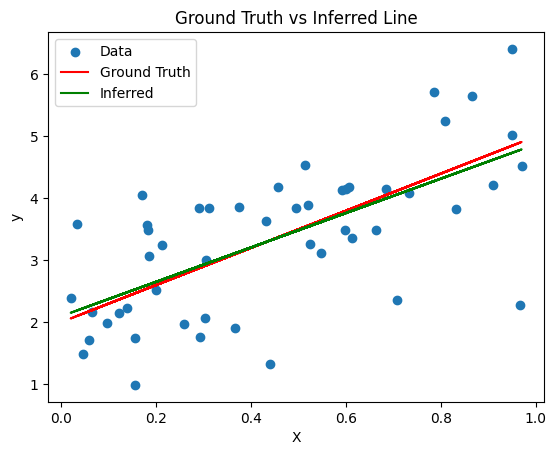

In [4]:
import matplotlib.pyplot as plt

def normal_eq(X, y):
    X_wi = np.c_[np.ones(X.shape[0]), X]
    XTX = np.dot(X_wi.T, X_wi)
    XTy = np.dot(X_wi.T, y)
    beta = np.dot(np.linalg.inv(XTX), XTy)
    return beta

np.random.seed(42)
n = 50
X = np.random.rand(n, 1)
noise = np.random.normal(0, 1, (n, 1))
y = 3 * X + 2 + noise

b = normal_eq(X, y)

plt.scatter(X, y, label='Data')
plt.plot(X, 3*X + 2, color='red', label='Ground Truth')
plt.plot(X, np.dot(np.c_[np.ones(X.shape[0]), X], b), color='green', label='Inferred')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Ground Truth vs Inferred Line')
plt.legend()
plt.show()

### Principal Component Analysis

PCA is a technique used to transform a dataset by finding a new set of orthogonal basis vectors, called principal components, that capture the maximum variance in the data. These principal components are determined by computing the eigenvectors of the covariance matrix of the dataset.

It is best expland with in a few steps:

1. **Standardization**
2. **Covariance Matrix**
3. **Eigendecomposition**
4. **Selection of Principal Components**
5. **Dimensionality Reduction**

We implement this below:

In [5]:
def pca(X, n_comp):
    X_s = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    cov = np.cov(X_s, rowvar=False)
    e_val, e_vec = np.linalg.eig(cov)
    s_ind = np.argsort(e_val)[::-1]
    s_e_vec = e_vec[:, s_ind]
    sel_e_vec = s_e_vec[:, :n_comp]
    proj_data = np.dot(X_s, sel_e_vec)
    return proj_data

np.random.seed(42)
X = np.random.rand(100, 5)

proj_data_custom = pca(X, n_comp=2)
print("Projected data shape:", proj_data_custom.shape)
print("First few rows of projected data:\n", proj_data_custom[:5])

Projected data shape: (100, 2)
First few rows of projected data:
 [[-1.48584759  0.10517099]
 [-0.09087782  1.46554212]
 [-2.80234709  0.29750159]
 [-0.54966191  0.02257206]
 [ 0.84682029 -0.75997465]]
